# Imports

In [67]:
import pandas as pd 
import matplotlib.pyplot as plt
import networkit as nk
import networkx as nx
import tqdm
import numpy as np
import glob

from sklearn.metrics import ndcg_score

# Load source data

In [211]:
nyc_taxi_df = pd.concat([pd.read_parquet(filepath) for filepath in glob.glob("../data/nyc_taxi/yellow*.parquet")[:3]], ignore_index=True)

nyc_taxi_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,None
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262,263,2,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5,None
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74,7,2,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0,None
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145,145,2,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0,None
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5,None


In [71]:
nyc_taxi_weighted_df = nyc_taxi_df[["PULocationID", "DOLocationID", "tpep_dropoff_datetime"]].groupby(by=["PULocationID", "DOLocationID"])["tpep_dropoff_datetime"].count().reset_index()

nyc_taxi_weighted_df.head()

,PULocationID,DOLocationID,tpep_dropoff_datetime
0,1,1,1748
1,1,16,1
2,1,21,1
3,1,23,1
4,1,43,1


In [156]:
PU_total_revenue_df = nyc_taxi_df.groupby("PULocationID")["total_amount"].sum().reset_index().sort_values("total_amount", ascending=False)

PU_total_revenue_df.head()

,PULocationID,total_amount
128,132,40446499.93
134,138,23929887.32
157,161,15480609.56
226,230,13908667.26
158,162,13614055.41


In [193]:
unit_revenue_df = nyc_taxi_df.groupby("PULocationID")[["total_amount", "trip_distance"]].sum().reset_index()
unit_revenue_df["unit_revenue"] = unit_revenue_df["total_amount"]/unit_revenue_df["trip_distance"]
unit_revenue_df.sort_values("unit_revenue", ascending=False, inplace=True)

unit_revenue_df.head()

,PULocationID,total_amount,trip_distance,unit_revenue
0,1,218325.22,3592.86,60.766414
261,265,1046910.47,38429.74,27.242195
29,30,2312.17,141.31,16.362395
195,199,15.36,0.95,16.168421
95,96,12510.82,796.87,15.699951


In [190]:
nyc_taxi_df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,unit_revenue
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.1,1.0,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,None,43.000000
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.1,1.0,N,262,263,2,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5,None,63.000000
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.5,1.0,N,74,7,2,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0,None,4.177778
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.9,1.0,N,145,145,2,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0,None,4.777778
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.8,1.0,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5,None,8.861111
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.7,1.0,N,79,125,1,9.5,3.0,0.5,1.00,0.0,0.3,14.30,2.5,None,8.411765
6,1,2019-06-01 00:46:46,2019-06-01 00:50:55,4.0,0.7,1.0,N,211,148,2,4.5,3.0,0.5,0.00,0.0,0.3,8.30,2.5,None,11.857143
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.3,1.0,N,79,249,1,7.5,3.0,0.5,1.00,0.0,0.3,12.30,2.5,None,9.461538
8,1,2019-06-01 00:09:57,2019-06-01 00:25:54,2.0,2.1,1.0,N,158,68,2,11.5,3.0,0.5,0.00,0.0,0.3,15.30,2.5,None,7.285714
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.7,1.0,N,186,243,1,31.5,3.0,0.5,7.05,0.0,0.3,42.35,2.5,None,4.867816


# Generate networkit graph

In [72]:
%%time

g = nk.Graph(directed=True)

for row in nyc_taxi_df[["PULocationID", "DOLocationID"]].to_records(index=False).tolist():
    g.addEdge(row[0], row[1], addMissing=True)

print("Number of nodes: ", g.numberOfNodes())
print("Number of edges: ", g.numberOfEdges())    

Number of nodes:  266
Number of edges:  20880424
CPU times: user 8.1 s, sys: 1.08 s, total: 9.18 s
Wall time: 9.32 s


# Generate networkx graph

In [14]:
%%time

gx = nx.DiGraph()

gx.add_weighted_edges_from(nyc_taxi_weighted_df.to_records(index=False).tolist())

print("Number of nodes: ", gx.number_of_nodes())
print("Number of edges: ", gx.number_of_edges())  

Number of nodes:  261
Number of edges:  32729
CPU times: user 50.9 ms, sys: 5.44 ms, total: 56.3 ms
Wall time: 75.6 ms


# Compare centrality measures

In [73]:
centrality = {}

## Outdegree

In [115]:
%%time

centrality["outdegree"] = [(node, sum([g.degreeOut(neighbor_node) for neighbor_node in g.iterNeighbors(node)])) for node in g.iterNodes()]
centrality["outdegree"] = sorted(centrality["outdegree"], key = lambda x: x[1], reverse=True)
centrality["outdegree"][:10]

CPU times: user 2.27 s, sys: 106 ms, total: 2.37 s
Wall time: 2.38 s


[(237, 505862401770),
 (161, 434443039527),
 (236, 426514976088),
 (162, 375301948458),
 (186, 347558091324),
 (230, 334468737946),
 (170, 316085964390),
 (48, 305983450129),
 (142, 302610229191),
 (163, 282345470312)]

## Revenue

In [212]:
centrality["revenue"] = PU_total_revenue_df["PULocationID"].to_list()
centrality["revenue"][:10]

[132, 138, 161, 230, 162, 186, 237, 236, 48, 170]

## Degree centrality

In [104]:
%%time

centrality["degree"] = nk.centrality.DegreeCentrality(g)
centrality["degree"].run()
centrality["degree"].ranking()[:10]

CPU times: user 2.19 ms, sys: 1.36 ms, total: 3.55 ms
Wall time: 853 µs


[(237, 888550.0),
 (161, 846981.0),
 (236, 786512.0),
 (162, 759254.0),
 (186, 744075.0),
 (132, 719652.0),
 (230, 703453.0),
 (48, 665536.0),
 (170, 657893.0),
 (234, 612619.0)]

## Betweenness centrality 

In [75]:
%%time

centrality["betweenness"] = nk.centrality.Betweenness(g)
centrality["betweenness"].run()
centrality["betweenness"].ranking()[:10]

CPU times: user 1min 50s, sys: 2.73 s, total: 1min 53s
Wall time: 10.3 s


[(132, 5819.658803529627),
 (138, 1555.2492354060396),
 (170, 1284.6154168683659),
 (161, 1063.5218332338752),
 (230, 1015.4987973068023),
 (231, 807.8454862650535),
 (48, 795.8228757948912),
 (264, 751.8929122837028),
 (140, 677.4441971459421),
 (186, 675.6085760546856)]

## Closeness centrality

In [76]:
%%time

centrality["closeness"] = nk.centrality.Closeness(g, True, nk.centrality.ClosenessVariant.Generalized)
centrality["closeness"].run()
centrality["closeness"].ranking()[:10]

CPU times: user 15.9 s, sys: 51.2 ms, total: 16 s
Wall time: 1.44 s


[(132, 0.9811892510005717),
 (138, 0.9738118882110938),
 (164, 0.9738118882110938),
 (48, 0.9701646526747226),
 (79, 0.9701646526747226),
 (161, 0.9701646526747226),
 (162, 0.9701646526747226),
 (230, 0.9701646526747226),
 (100, 0.9665446353139961),
 (107, 0.9665446353139961)]

## Top k closeness centrality

In [126]:
%%time

centrality["topkcloseness"] = nk.centrality.TopCloseness(g, k=100, first_heu=True, sec_heu=True)
centrality["topkcloseness"].run()
list(zip(centrality["topkcloseness"].topkNodesList(), centrality["topkcloseness"].topkScoresList()))[:10]

CPU times: user 13.9 s, sys: 90.3 ms, total: 14 s
Wall time: 1.34 s


[(132, 0.9811892510005717),
 (138, 0.9738118882110937),
 (164, 0.9738118882110937),
 (48, 0.9701646526747225),
 (79, 0.9701646526747225),
 (161, 0.9701646526747225),
 (162, 0.9701646526747225),
 (230, 0.9701646526747225),
 (100, 0.9665446353139963),
 (107, 0.9665446353139963)]

## Eigenvector centrality

In [86]:
%%time

centrality["eigenvector"] = nk.centrality.EigenvectorCentrality(g)
centrality["eigenvector"].run()
centrality["eigenvector"].ranking()[:10]

CPU times: user 3.59 s, sys: 120 ms, total: 3.71 s
Wall time: 351 ms


[(236, 0.35660225801150014),
 (237, 0.3512548155206102),
 (161, 0.29503779226330196),
 (162, 0.23563017491578633),
 (170, 0.2083957828233215),
 (230, 0.20629884542961494),
 (142, 0.199372459961929),
 (141, 0.19098325391750565),
 (48, 0.18046415616189848),
 (239, 0.1775128813116595)]

## Pagerank centrality

In [81]:
%%time

centrality["pagerank"] = nk.centrality.PageRank(g, damp=0.85, tol=1e-9)
centrality["pagerank"].run()
centrality["pagerank"].ranking()[:10]

CPU times: user 2.89 s, sys: 29.5 ms, total: 2.91 s
Wall time: 288 ms


[(264, 0.040102376041534986),
 (236, 0.02286254302121352),
 (161, 0.022343325951096754),
 (237, 0.021456308113371556),
 (170, 0.019047433147212915),
 (230, 0.017749122794730128),
 (162, 0.017686118006468785),
 (48, 0.01639280726250008),
 (142, 0.015702011350520368),
 (239, 0.015332633613601543)]

## NDCG@20 comparison

## w.r.t topkcloseness

In [176]:
ndcg_scores = {}

for k in [5, 10, 20, 30, 40, 50]:

    ndcg_scores[k] = {}

    y_score = [centrality["topkcloseness"].topkNodesList()[:k]]

    for centrality_measure in ["outdegree", "degree", "betweenness", "closeness", "eigenvector", "pagerank"]:

        if centrality_measure == "outdegree":
            y_true = [[row[0] for row in centrality[centrality_measure][:k]]]

        else:
            y_true = [[row[0] for row in centrality[centrality_measure].ranking()[:k]]]
        
        ndcg_scores[k][centrality_measure] = ndcg_score(y_true, y_score, k=k)

print(ndcg_scores)

{5: {'outdegree': 0.9802003514876603, 'degree': 0.9802003514876603, 'betweenness': 0.9169933178484533, 'closeness': 1.0, 'eigenvector': 0.936086480971909, 'pagerank': 0.9097038564396647}, 10: {'outdegree': 0.8422678989144964, 'degree': 0.8398823776040713, 'betweenness': 0.9372705975961665, 'closeness': 1.0, 'eigenvector': 0.8838673456413113, 'pagerank': 0.8025561857932396}, 20: {'outdegree': 0.8976912954031848, 'degree': 0.8422705220731262, 'betweenness': 0.8382141711931822, 'closeness': 1.0, 'eigenvector': 0.8416272245286782, 'pagerank': 0.8322052278047525}, 30: {'outdegree': 0.8835433036319539, 'degree': 0.840566588007736, 'betweenness': 0.8650978828180543, 'closeness': 1.0000000000000002, 'eigenvector': 0.9219549172446244, 'pagerank': 0.9016027717208137}, 40: {'outdegree': 0.8768141196667536, 'degree': 0.828560867003561, 'betweenness': 0.8738744351348068, 'closeness': 0.9999999999999998, 'eigenvector': 0.9165424190149815, 'pagerank': 0.8911952265849241}, 50: {'outdegree': 0.85211072

In [177]:
ndcg_scores_df = pd.DataFrame(ndcg_scores).T

ndcg_scores_df

,outdegree,degree,betweenness,closeness,eigenvector,pagerank
5,0.980200,0.980200,0.916993,1.0,0.936086,0.909704
10,0.842268,0.839882,0.937271,1.0,0.883867,0.802556
20,0.897691,0.842271,0.838214,1.0,0.841627,0.832205
30,0.883543,0.840567,0.865098,1.0,0.921955,0.901603
40,0.876814,0.828561,0.873874,1.0,0.916542,0.891195
50,0.852111,0.881321,0.818153,1.0,0.881187,0.825251


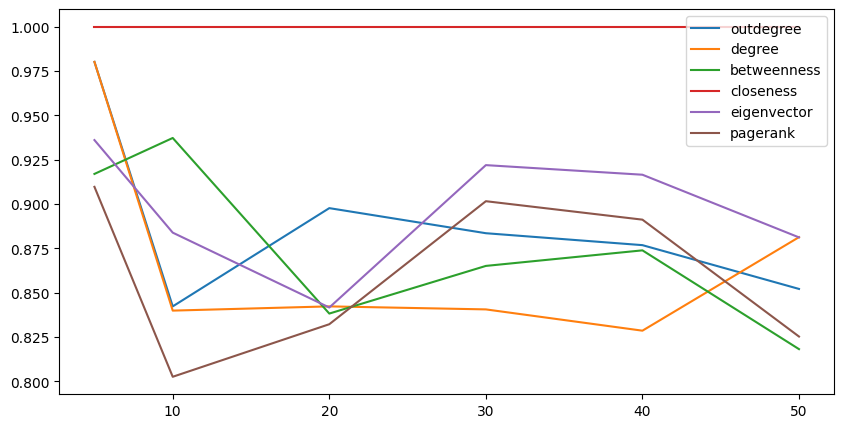

In [178]:
plt.figure(figsize=(10, 5))

for column in ndcg_scores_df.columns:
    plt.plot(ndcg_scores_df.index, ndcg_scores_df[column], label=column)

plt.legend()
plt.show()

## w.r.t top revenue locations

In [217]:
ndcg_scores = {}

for k in [5, 10, 15, 20]:

    ndcg_scores[k] = {}

    y_true = [centrality["revenue"][:k]]

    for centrality_measure in ["outdegree", "degree", "betweenness", "closeness", "topkcloseness", "eigenvector", "pagerank"]:

        if centrality_measure == "outdegree":
            y_score = [[row[0] for row in centrality[centrality_measure][:k]]]

        elif centrality_measure == "topkcloseness":
            y_score = [centrality["topkcloseness"].topkNodesList()[:k]]

        else:
            y_score = [[row[0] for row in centrality[centrality_measure].ranking()[:k]]]
        
        ndcg_scores[k][centrality_measure] = ndcg_score(y_true, y_score, k=k)

print(ndcg_scores)

{5: {'outdegree': 0.8926096124367476, 'degree': 0.8926096124367476, 'betweenness': 0.9347661092595823, 'closeness': 0.9036818090243446, 'topkcloseness': 0.9036818090243446, 'eigenvector': 0.8861124933616022, 'pagerank': 0.9139123252718566}, 10: {'outdegree': 0.8786028299556579, 'degree': 0.8708529743695195, 'betweenness': 0.9582242163715621, 'closeness': 0.9630108350234612, 'topkcloseness': 0.9630108350234612, 'eigenvector': 0.8899017162284686, 'pagerank': 0.8836911823928519}, 15: {'outdegree': 0.8952098167360382, 'degree': 0.8177624908322204, 'betweenness': 0.9399681388287692, 'closeness': 0.9110227913366573, 'topkcloseness': 0.9110227913366573, 'eigenvector': 0.8175434514322661, 'pagerank': 0.8624109172169769}, 20: {'outdegree': 0.8934626648400217, 'degree': 0.8327001062703603, 'betweenness': 0.9148999999515345, 'closeness': 0.8689273371938726, 'topkcloseness': 0.8689273371938726, 'eigenvector': 0.8301574722008351, 'pagerank': 0.8662045642986717}}


In [218]:
ndcg_scores_df = pd.DataFrame(ndcg_scores).T

ndcg_scores_df

,outdegree,degree,betweenness,closeness,topkcloseness,eigenvector,pagerank
5,0.892610,0.892610,0.934766,0.903682,0.903682,0.886112,0.913912
10,0.878603,0.870853,0.958224,0.963011,0.963011,0.889902,0.883691
15,0.895210,0.817762,0.939968,0.911023,0.911023,0.817543,0.862411
20,0.893463,0.832700,0.914900,0.868927,0.868927,0.830157,0.866205


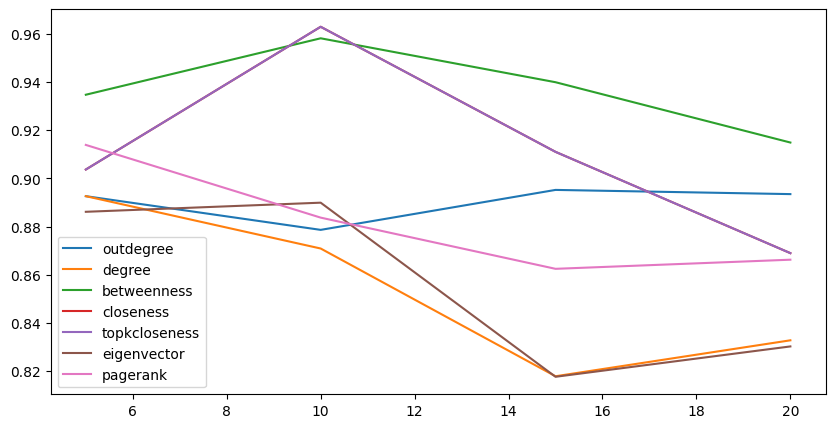

In [219]:
plt.figure(figsize=(10, 5))

for column in ndcg_scores_df.columns:
    plt.plot(ndcg_scores_df.index, ndcg_scores_df[column], label=column)

plt.legend()
plt.show()

# Revenue earned comparison

In [166]:
revenue = {}

for k in [5, 10, 20, 30, 40]:

    revenue[k] = {}

    for centrality_measure in ["outdegree", "degree", "betweenness", "closeness", "topkcloseness", "eigenvector", "pagerank"]:

        if centrality_measure == "outdegree":
            top_nodes = [[row[0] for row in centrality[centrality_measure][:k]]][0]

        elif centrality_measure == "topkcloseness":
            top_nodes = [centrality["topkcloseness"].topkNodesList()[:k]][0]

        else:
            top_nodes = [[row[0] for row in centrality[centrality_measure].ranking()[:k]]][0]
        
        revenue[k][centrality_measure] = PU_total_revenue_df[PU_total_revenue_df["PULocationID"].isin(top_nodes)]["total_amount"].sum()

print(revenue)

{5: {'outdegree': 68136121.09, 'degree': 68136121.09, 'betweenness': 105414551.37, 'closeness': 93317261.73, 'topkcloseness': 93317261.73, 'eigenvector': 66250698.78999999, 'pagerank': 56222207.87}, 10: {'outdegree': 125555781.2, 'degree': 156123083.38, 'betweenness': 147404665.36, 'closeness': 151819021.82999998, 'topkcloseness': 151819021.82999998, 'eigenvector': 117635465.41, 'pagerank': 113984515.49}, 20: {'outdegree': 255750380.04000002, 'degree': 257743240.37000003, 'betweenness': 235319515.59000003, 'closeness': 225813119.67000002, 'topkcloseness': 225813119.67000002, 'eigenvector': 202237959.12, 'pagerank': 195760733.77000004}, 30: {'outdegree': 317920540.09000003, 'degree': 319538965.87000006, 'betweenness': 300018399.47999996, 'closeness': 303177792.92, 'topkcloseness': 303177792.92, 'eigenvector': 276687719.18999994, 'pagerank': 249497341.48000002}, 40: {'outdegree': 361165879.69000006, 'degree': 361165879.69000006, 'betweenness': 336386597.14, 'closeness': 350946899.0900000

In [167]:
revenue_df = pd.DataFrame(revenue).T

revenue_df

,outdegree,degree,betweenness,closeness,topkcloseness,eigenvector,pagerank
5,6.813612e+07,6.813612e+07,1.054146e+08,9.331726e+07,9.331726e+07,6.625070e+07,5.622221e+07
10,1.255558e+08,1.561231e+08,1.474047e+08,1.518190e+08,1.518190e+08,1.176355e+08,1.139845e+08
20,2.557504e+08,2.577432e+08,2.353195e+08,2.258131e+08,2.258131e+08,2.022380e+08,1.957607e+08
30,3.179205e+08,3.195390e+08,3.000184e+08,3.031778e+08,3.031778e+08,2.766877e+08,2.494973e+08
40,3.611659e+08,3.611659e+08,3.363866e+08,3.509469e+08,3.509469e+08,3.580560e+08,3.436102e+08


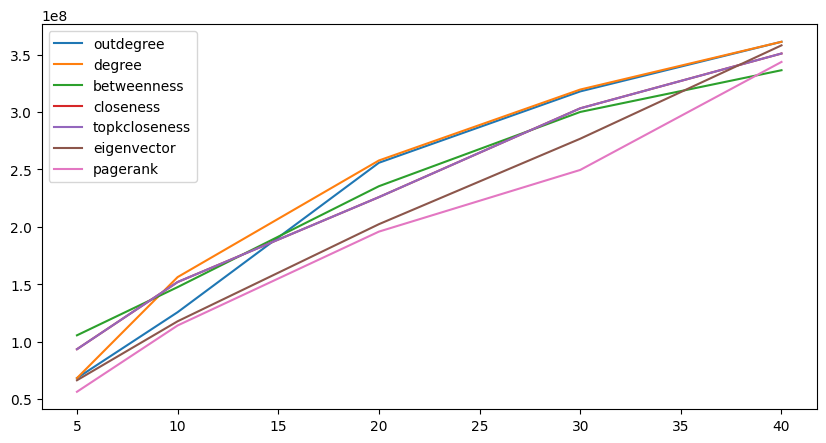

In [168]:
plt.figure(figsize=(10, 5))

for column in revenue_df.columns:
    plt.plot(revenue_df.index, revenue_df[column], label=column)

plt.legend()
plt.show()

# Trip distance comparison

In [195]:
mean_revenue = {}

for k in [5, 10, 20, 30, 40]:

    mean_revenue[k] = {}

    for centrality_measure in ["outdegree", "degree", "betweenness", "closeness", "topkcloseness", "eigenvector", "pagerank"]:

        if centrality_measure == "outdegree":
            top_nodes = [[row[0] for row in centrality[centrality_measure][:k]]][0]

        elif centrality_measure == "topkcloseness":
            top_nodes = [centrality["topkcloseness"].topkNodesList()[:k]][0]

        else:
            top_nodes = [[row[0] for row in centrality[centrality_measure].ranking()[:k]]][0]
        
        mean_revenue[k][centrality_measure] = unit_revenue_df[unit_revenue_df["PULocationID"].isin(top_nodes)]["unit_revenue"].mean()

print(mean_revenue)

{5: {'outdegree': 7.879957168997189, 'degree': 7.879957168997189, 'betweenness': 6.106919822830221, 'closeness': 5.9657005113508355, 'topkcloseness': 5.9657005113508355, 'eigenvector': 7.84978900356096, 'pagerank': 7.993046871716163}, 10: {'outdegree': 7.593570068909616, 'degree': 7.273192485328326, 'betweenness': 6.7029111799939045, 'closeness': 6.68175659612204, 'topkcloseness': 6.68175659612204, 'eigenvector': 7.57930153507502, 'pagerank': 7.634361956329045}, 20: {'outdegree': 7.263869590158288, 'degree': 7.21411437926416, 'betweenness': 7.065461778811098, 'closeness': 6.856856028906783, 'topkcloseness': 6.856856028906783, 'eigenvector': 7.535334823688946, 'pagerank': 7.476163093546194}, 30: {'outdegree': 7.28546705118655, 'degree': 7.261421983336405, 'betweenness': 7.07123165423792, 'closeness': 7.033119939997462, 'topkcloseness': 7.033119939997462, 'eigenvector': 7.3216692240313295, 'pagerank': 8.012826178460573}, 40: {'outdegree': 7.159055190644378, 'degree': 7.159055190644378, '

In [196]:
mean_revenue_df = pd.DataFrame(mean_revenue).T

mean_revenue_df

,outdegree,degree,betweenness,closeness,topkcloseness,eigenvector,pagerank
5,7.879957,7.879957,6.106920,5.965701,5.965701,7.849789,7.993047
10,7.593570,7.273192,6.702911,6.681757,6.681757,7.579302,7.634362
20,7.263870,7.214114,7.065462,6.856856,6.856856,7.535335,7.476163
30,7.285467,7.261422,7.071232,7.033120,7.033120,7.321669,8.012826
40,7.159055,7.159055,6.959068,7.006963,7.006963,7.140784,7.591433


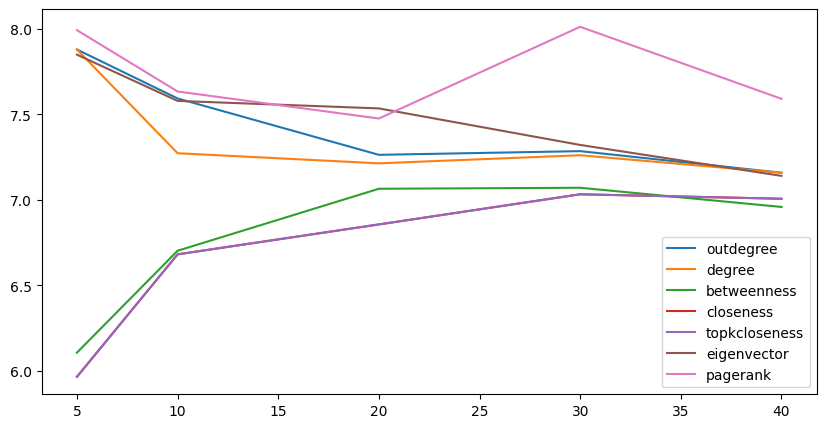

In [197]:
plt.figure(figsize=(10, 5))

for column in mean_revenue_df.columns:
    plt.plot(mean_revenue_df.index, mean_revenue_df[column], label=column)

plt.legend()
plt.show()